# DOPPELGANGER #

## Ever wondered how your "doppelganger" dog would look like? 

![Doppelganger](../img/dogs.png)

Photos by Gerrard Gethings (https://www.boredpanda.com/dogs-look-like-owners-gerrard-gethings)


# EXPERIMENT LOCALLY

### Prepare Environment
Install and import needed modules.

In [ ]:
#!pip install --upgrade pip
#!pip install pandas sklearn matplotlib
#!pip install pillow

In [28]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Set image path and explore enivornment.

In [29]:
images_path = 'images/'
len(os.listdir(os.path.join(images_path)))

121

Set parameters.

In [30]:
batch_size = 200
img_w_size = 299
img_h_size = 299

Build Data Generator

In [31]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

image_generator = datagen.flow_from_directory(
    images_path,
    target_size=(img_w_size, img_h_size),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

Found 20583 images belonging to 121 classes.


In [32]:
images = image_generator.next()
images.shape

(200, 299, 299, 3)

### Show a sample picture!

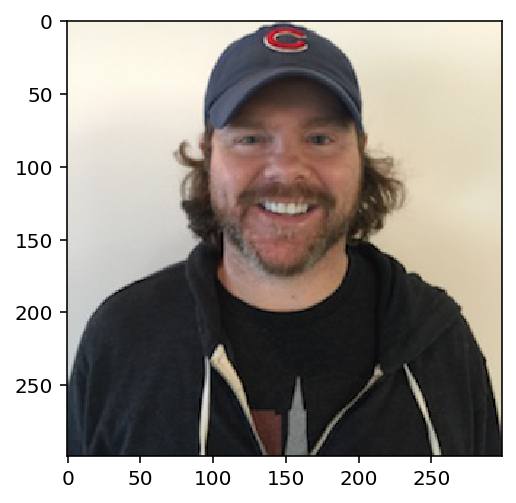

In [34]:
sample_image_idx = 2
plt.imshow((images[sample_image_idx] + 1) / 2)

## Transform Images to Lower Feature Space (Bottleneck) ##

In [35]:
base_model = Xception(include_top=False,
                      weights='imagenet',
                      input_shape=(img_w_size, img_h_size, 3),
                      pooling='avg')

In [36]:
bottlenecks = base_model.predict(images)
bottlenecks.shape

(200, 2048)

### Show Bottleneck

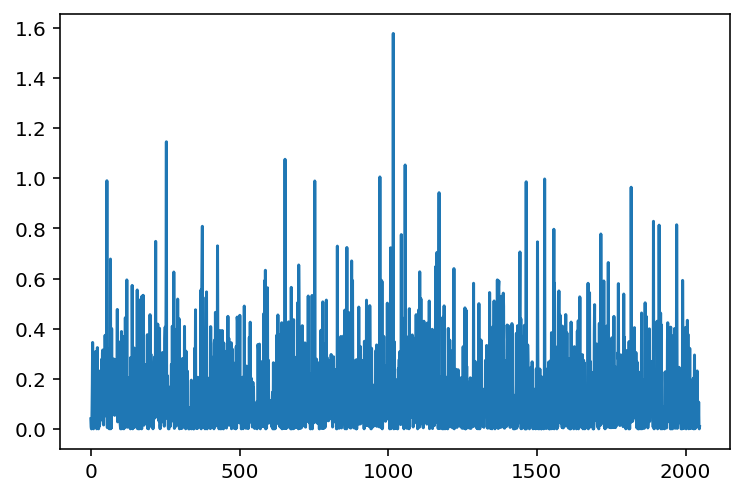

In [42]:
plt.plot(bottlenecks[0])
plt.show()

In [43]:
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('euclidean')

### Calculate pairwise distances

In [44]:
bn_dist = dist.pairwise(bottlenecks)
bn_dist.shape

(200, 200)

## Pre-Process Image Similarities ##

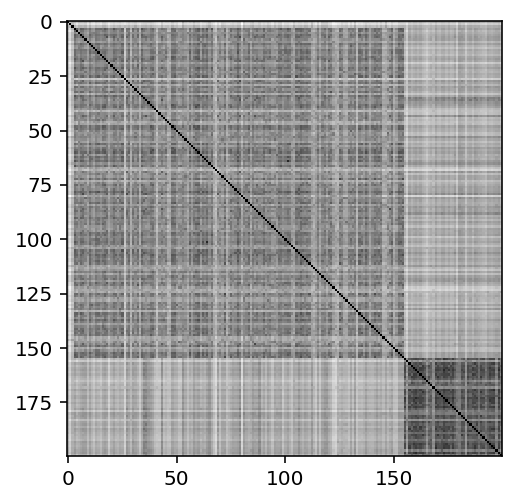

In [45]:
plt.imshow(bn_dist, cmap='gray')

Set visualization parameters.

In [46]:
n_rows = 5
n_cols = 5
n_result_images = n_rows * n_cols

# Find Similar Images #

## Define `image_search()`

In [47]:
def image_search(img_index, n_rows=n_rows, n_columns=n_cols):
    n_images = n_rows * n_cols

    # create Pandas Series with distances from image
    dist_from_sel = pd.Series(bn_dist[img_index])
    
    # sort Series and get top n_images
    retrieved_indexes = dist_from_sel.sort_values().head(n_images)
    retrieved_images = []
    
    # create figure, loop over closest images indices 
    # and display them
    plt.figure(figsize=(10, 10))
    i = 1
    for idx in retrieved_indexes.index:
        plt.subplot(n_rows, n_cols, i)
        plt.imshow((images[idx] + 1) / 2)
        if i == 1:
            plt.title('Selected image')
        else:
            plt.title("Dist: {:0.4f}".format(retrieved_indexes[idx]))
        i += 1
        retrieved_images += [images[idx]]
        
    plt.tight_layout()
    
    return np.array(retrieved_images)

## Perform Image Search

### TODO: Put human images into images/0_Human/ folder

(25, 299, 299, 3)

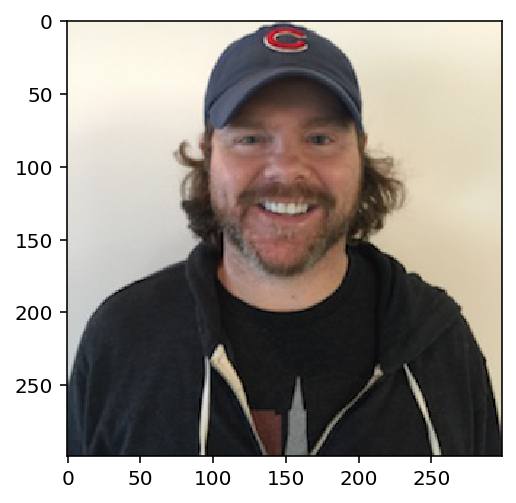

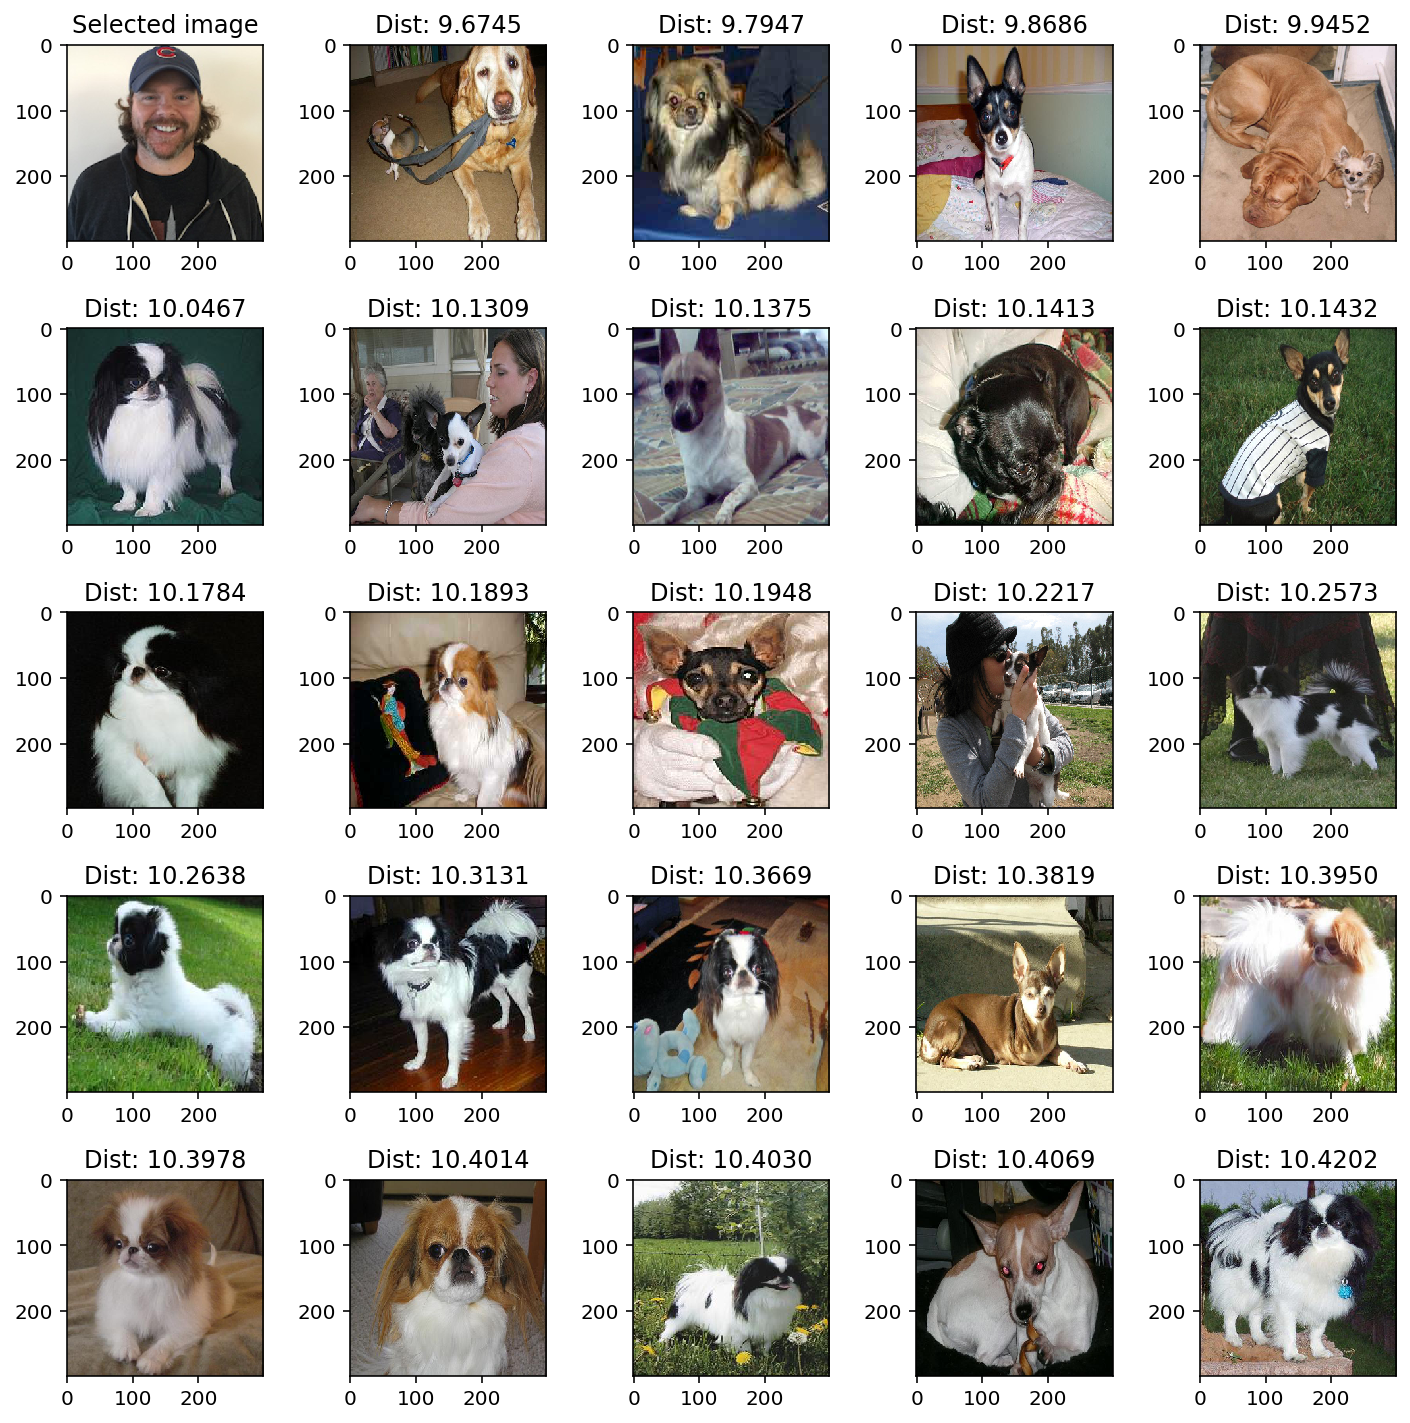

In [48]:
similar_to_idx = 2
plt.imshow((images[similar_to_idx] + 1) / 2)

similar_images_sorted = image_search(similar_to_idx)
similar_images_sorted.shape

## Convert images to gray-scale ##

In [49]:
grayscaled_similar_images_sorted = similar_images_sorted.mean(axis=3)
flattened_grayscale_images = grayscaled_similar_images_sorted.reshape(n_result_images, -1)
flattened_grayscale_images.shape

(25, 89401)

In [50]:
_, h, w = grayscaled_similar_images_sorted.shape

# Compute a PCA 
n_components = 10

pca = PCA(n_components=n_components, whiten=True).fit(flattened_grayscale_images)

# apply PCA transformation to training data
pca_transformed = pca.transform(flattened_grayscale_images)

## Visualize Eigenfaces

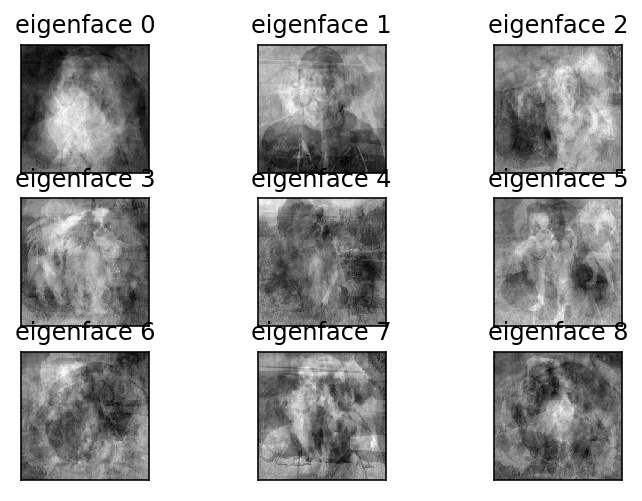

In [51]:
def plot_gallery(images, titles, h, w, rows=n_rows, cols=n_cols):
    plt.figure()
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].reshape(h, w), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())

eigenfaces = pca.components_.reshape((n_components, h, w))
eigenface_titles = ["eigenface {0}".format(i) for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w, 3, 3)

plt.show()

## Show Average Face

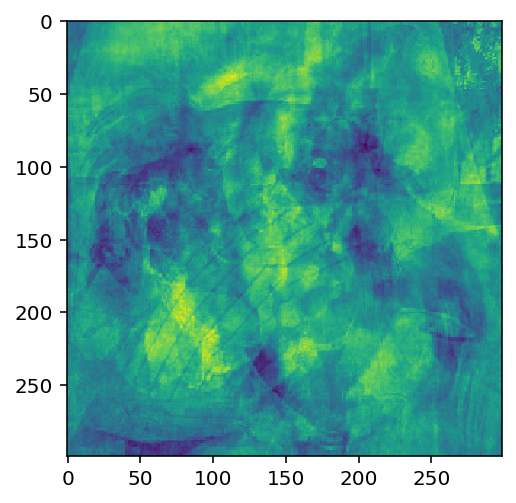

In [52]:
average_face = eigenfaces[9]
plt.imshow((average_face + 1) / 2)

# BUILD CONTAINER

In [40]:
!cat code/training/doppelganger-train.py

# References:
#  https://towardsdatascience.com/an-intuitive-guide-to-deep-network-architectures-65fdc477db41
#  https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html

import numpy as np
import pandas as pd
import os
import time
import random
import json

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input

from sklearn.neighbors import DistanceMetric

images_path = 'images/'
batch_size = 200
img_w_size = 299
img_h_size = 299

print('** LOADING IMAGES **')
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
image_generator = datagen.flow_from_directory(
            images_path,
            target_size=(img_w_size, img_h_size),
            batch_size=batch_size,
            class_mode=None,
            shuffle=False)
# Note:  This needs to stay up here because we use it later to resolve the i

In [38]:
!cat code/training/Dockerfile

FROM tensorflow/tensorflow:1.13.1

COPY doppelganger-train.py /doppelganger-train.py

CMD [ "python", "doppelganger-train.py" ]

In [37]:
!cat code/training/doppelganger-train.yaml

apiVersion: v1
kind: Pod
metadata:
  name: doppelganger-train
  labels:
    app: doppelganger-train
    type: training
    framework: tensorflow
spec:
  restartPolicy: OnFailure
  containers:
  - name: doppelganger-train
    image: tensorflow/tensorflow:1.13.1
    command:
      - "python"
      - "doppelganger-train.py"
      - "--model_export_path"
      - "s3://antje-doppelganger-data/trained_model/tf_saved_model"
      - "--model_summary_path"
      - "s3://antje-doppelganger-data/trained_model/tf_summary"
      - "--epochs"
      - "40"
    env:
      - name: AWS_REGION
        value: $AWS_REGION

# RUN TRAINING POD

In [ ]:
#!kubectl apply -f code/training/doppelganger-train.yaml

# RUN INFERENCE POD
Use the previously trained model and run inference using TensorFlow and Keras on Amazon EKS

In [41]:
#!cat code/inference/doppelganger-predict.yaml

In [ ]:
#!kubectl apply -f code/inference/doppelganger-predict.yaml

### Port forward for local testing

In [ ]:
#kubectl port-forward `kubectl get pods -l=app=doppelganger-predict,type=inference -o jsonpath='{.items[0].metadata.name}' --field-selector=status.phase=Running` 8500:8500 &

### Make a prediction
Use the script inference_client.py to make prediction request. It will randomly pick one image from test dataset and make prediction.

In [ ]:
#curl -LO https://eksworkshop.com/kubeflow/kubeflow.files/inference_client.py
#$ python inference_client.py --endpoint http://localhost:8500/v1/models/mnist:predict